# 결측치 채우기
- 서울시 공동주택 아파트 정보 데이터를 활용하여 결측치 채우기

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings;warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

In [2]:
train_path = './train.csv'
test_path  = './test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [3]:
train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

In [4]:
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

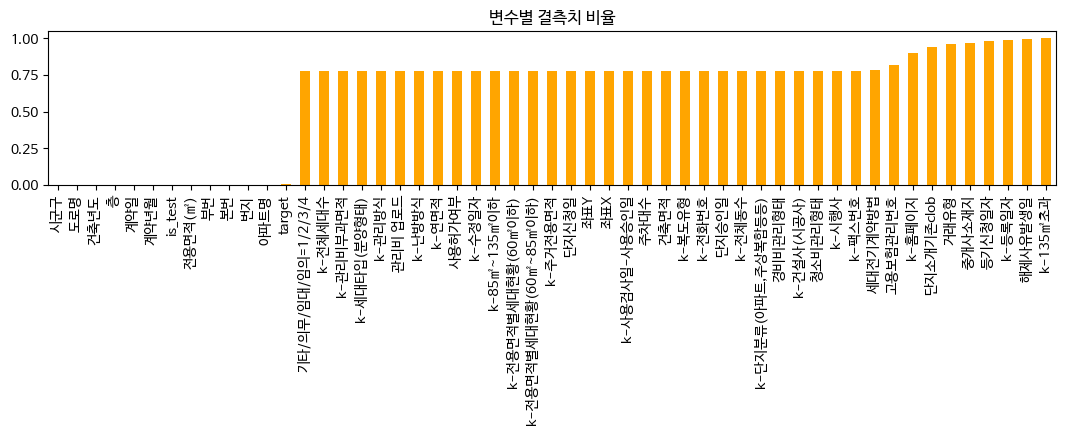

In [5]:
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing >= 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [6]:
house_df_path = "./서울시 공동주택 아파트 정보.csv"
house_df = pd.read_csv(house_df_path, encoding='cp949')

In [7]:
# '도로명주소'을 기준으로 df_train의 결측치 ('아파트명'은 같은 아파트임에도 서로 일치하지 않는 항목이 많아서)
house_df['도로명주소'] = house_df['주소(도로명)'] + ' ' + house_df['주소(도로상세주소)']
house_df = house_df.drop_duplicates(subset='도로명주소')

In [8]:
# house_df_unique에서 '도로명주소'가 같은 경우 수치형인 열은 평균값으로, 범주형인 열은 최빈값으로 중복값 대체
def handle_duplicates(df):
    duplicates = df.duplicated(subset=['도로명주소'])
    for col in df.columns:
        if col != '도로명주소':
            if df[col].dtype == 'int64':
                df[col] = df.groupby('도로명주소')[col].transform(lambda x: x.mean() if not x.isnull().all() else x)
            else:
                df[col] = df.groupby('도로명주소')[col].transform(lambda x: x.mode().iloc[0] if not x.isnull().all() else x)
    df = df.drop_duplicates(subset=['도로명주소'])
    return df

house_df = handle_duplicates(house_df)

In [9]:
# concat과 house_df_unique에 공통으로 존재하는 열 찾기
common_cols = []
for col_1 in (concat.columns):
    for col_2 in list(list(house_df.columns)):
        if col_1 == col_2:
            common_cols.append(col_1)
            break
common_cols.remove('k-전화번호')
common_cols.remove('k-팩스번호')
common_cols.remove('k-홈페이지')

In [10]:
# concat의 결측치를 house_df_unique로 채우기
for col in common_cols:
    concat[col] = concat[col].fillna(concat['도로명'].map(house_df.set_index('도로명주소')[col]))
concat[col] = concat['아파트명'].fillna(concat['도로명'].map(house_df.set_index('도로명주소')['k-아파트명']))

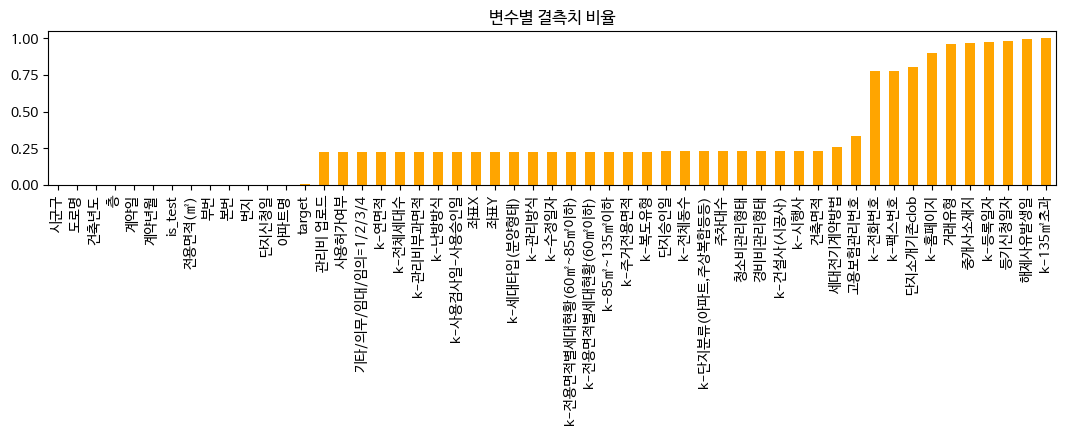

In [11]:
fig = plt.figure(figsize=(13, 2))
missing_2 = concat.isnull().sum() / concat.shape[0]
missing_2 = missing_2[missing_2 >= 0]
missing_2.sort_values(inplace=True)
missing_2.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [12]:
# 결측치가 50만개 이상인 변수 제외
cols_selected = list(concat.columns[concat.isnull().sum() <= 500000])
concat_new = concat[cols_selected]
print(cols_selected)

['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']


# 아파트명 변수의 값을 단순화하기
- 데이콘 "아파트 실거래가 예측" 대회의 "LightGBM + Optuna로 top 10안에 들어봅시다." 코드 참고

In [13]:
concat['k-건설사(시공사)'] = concat['k-건설사(시공사)'].astype(str)

In [14]:
# 여러 건설사가 같이 시공하였을 시 더 브랜드 평판이 높은 건설사 혹은 데이터가 더 많은 건설사로 대체
def simple_apt(apt):
    if '현대건설' in apt or '힐스테이트' in apt:
        return '현대건설'
    elif '삼성물산' in apt:
        return '삼성물산'
    elif '대우건설' in apt or '푸르지오' in apt:
        return '대우건설'
    elif 'GS' in apt or 'gs' in apt or '지에스' in apt:
        return 'GS건설'
    elif '포스코' in apt:
        return '포스코건설'
    elif '래미안' in apt or '삼성물산' in apt:
        return '삼성물산'
    elif 'DL' in apt:
        return 'DL E&C'
    elif '롯데건설' in apt or '롯데캐슬' in apt:
        return '롯데건설'
    elif '현대산업' in apt:
        return '현대산업개발'
    elif '한화' in apt:
        return '한화건설'
    elif '쌍용' in apt:
        return '쌍용건설'
    elif apt in ['대한주택공사', 'LH공사', '한국토지주택공사', '한국주택공사', 'LH']:
        return '한국토지주택공사'
    elif '우성' in apt:
        return '우성건설'
    elif '한신' in apt:
        return '한신공영'
    elif '두산건설' in apt:
        return '두산건설'
    elif apt in ['동아건설', '(주)동아건설', '동아건설산업(주)', '동아건설산업', '동아건설(주)', '(주)동아건설산업', '동아,효성', '동아주택']:
        return '동아건설'
    elif '대림산업' in apt:
        return '대림산업'
    elif '벽산건설' in apt:
        return '벽산건설'
    elif '동부건설' in apt:
        return '동부건설'
    else:
        return 'Other'
    
    
concat['k-건설사(시공사)'] = concat['k-건설사(시공사)'].apply(simple_apt)
concat['k-건설사(시공사)'] = concat['k-건설사(시공사)'].fillna(value='Other') # 결측치도 'Other'로 통일
    

In [17]:
concat[concat['k-건설사(시공사)']!='Other']['k-건설사(시공사)'].value_counts().sum()

447103